# State Distribution Example

In this example, we plan to plot the distribution of system states. This helps researchers on serverless computing platforms to debug and test out their performance models with knowledge of system state distribution.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim

sim = Sim(arrival_rate=0.9, warm_service_rate=1/1.991, cold_service_rate=1/2.244,
            expiration_threshold=600, max_time=1e6)
sim.generate_trace(debug_print=False, progress=True)
sim.print_trace_results()

100%|██████████| 1000000/1000000 [00:42<00:00, 23357.30it/s]
Cold Starts / total requests: 	 1195 / 901002
Cold Start Probability: 	 0.0013
Rejection / total requests: 	 0 / 901002
Rejection Probability: 		 0.0000
Average Instance Life Span: 	 6445.8706
Average Server Count:  		 7.6859
Average Running Count:  	 1.7950
Average Idle Count:  		 5.8909


You can define any state representation you want based on the data present in the trace.
Here, we chose to use the number of servers as state.

In [3]:
sim.calculate_time_lengths()

# encode states
hist_states = []
for idx in range(len(sim.hist_server_count)):
    if sim.hist_server_count[idx] == 0:
        hist_states.append((0, 'd'))
    else:
        curr_server_count = sim.hist_server_count[idx]
        prev_server_count = sim.hist_server_count[idx-1]
        if curr_server_count > prev_server_count:
            hist_states.append((curr_server_count, 'u'))
        elif curr_server_count < prev_server_count:
            hist_states.append((curr_server_count, 'd'))
        else: # state hasn't changed
            hist_states.append(hist_states[-1])

vals, probs = sim.calculate_time_average(hist_states, skip_init_time=100)
sim.print_time_average(vals, probs)
residence_time_avgs = sim.get_average_residence_times(hist_states, skip_init_time=100)
residence_time_list = [residence_time_avgs[s] for s in vals]
df = pd.DataFrame(data = {'state': vals, 'prob': probs, 'sojourn_time': residence_time_list})
df = df.sort_values(by='state')
df

Value           Prob
(11, 'u')       0.0066
(6, 'u')        0.0007
(8, 'd')        0.0408
(10, 'u')       0.0319
(9, 'd')        0.0033
(12, 'u')       0.0012
(11, 'd')       0.0000
(7, 'u')        0.1263
(6, 'd')        0.0540
(10, 'd')       0.0000
(8, 'u')        0.3255
(5, 'd')        0.0000
(7, 'd')        0.2897
(9, 'u')        0.1200


,state,prob,sojourn_time
11,"(5, d)",2.151501e-06,2.151287
8,"(6, d)",5.403933e-02,203.135199
1,"(6, u)",7.001230e-04,350.026719
12,"(7, d)",2.896894e-01,489.505444
7,"(7, u)",1.262928e-01,472.959613
2,"(8, d)",4.080823e-02,163.872190
10,"(8, u)",3.254916e-01,550.692503
4,"(9, d)",3.276803e-03,49.643595
13,"(9, u)",1.200244e-01,481.977813
9,"(10, d)",1.180960e-05,0.908341


## Calculate Average Transition Times

In [4]:
residence_times, transition_times = sim.analyze_custom_states(hist_states, skip_init_time=100)
transition_counts = {}
for k in transition_times:
    transition_counts[k] = len(transition_times[k])

t_starts = [s[0] for s in transition_counts.keys()]
t_ends = [s[1] for s in transition_counts.keys()]
t_counts = [transition_counts[k] for k in transition_counts.keys()]
t_avgs = [np.mean(transition_times[s]) for s in transition_counts.keys()]

df = pd.DataFrame(data = {'start': t_starts, 'end': t_ends, 'count': t_counts, 'average': t_avgs})

t_totals = [df.loc[df['start'] == k[0], 'count'].sum() for k in transition_counts.keys()]
df['totals'] = t_totals
df['prob'] = df['count'] / df['totals']

df = df.sort_values(by='start')
df

,start,end,count,average,totals,prob
21,"(5, d)","(6, u)",1,2.151287,1,1.000000
12,"(6, d)","(7, u)",265,203.893357,266,0.996241
20,"(6, d)","(5, d)",1,2.223289,266,0.003759
0,"(6, u)","(7, u)",2,350.026719,2,1.000000
3,"(7, d)","(8, u)",369,547.678407,590,0.625424
11,"(7, d)","(6, d)",221,392.375021,590,0.374576
1,"(7, u)","(8, u)",222,336.052322,267,0.831461
13,"(7, u)","(6, d)",45,1148.368914,267,0.168539
10,"(8, d)","(9, u)",20,330.264296,249,0.080321
8,"(8, d)","(7, d)",229,149.340128,249,0.919679


## Calculate Transition Time Histograms

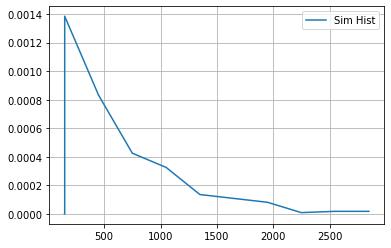

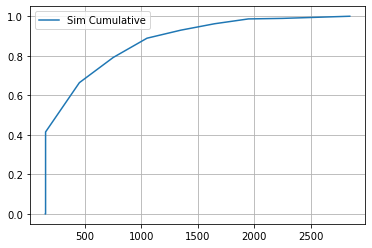

In [5]:
from pacssim.Utility import convert_hist_pdf

transition = ((7, 'd'),(8, 'u'))
traces = transition_times[transition]
num_bins = 10
base, hist_values, cumulative = convert_hist_pdf(traces, num_bins)

plt.figure()
plt.plot(base, hist_values, label='Sim Hist')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(base, cumulative, label='Sim Cumulative')
plt.legend()
plt.grid(True)

## Calculate Time Average of Server Count

Value           Prob
5               0.0000
6               0.0547
7               0.4160
8               0.3663
9               0.1233
10              0.0319
11              0.0066
12              0.0012


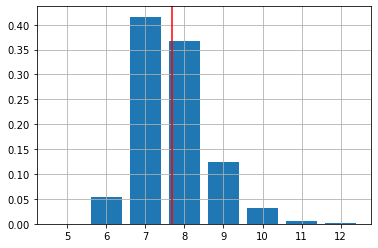

In [6]:
sim.calculate_time_lengths()

unq_vals, val_times = sim.calculate_time_average(sim.hist_server_count, skip_init_time=100)

plt.bar(unq_vals, val_times)
plt.grid(True)
plt.axvline(x=sim.get_average_server_count(), c='r')

sim.print_time_average(unq_vals, val_times)

In [7]:
pd.DataFrame(data = {'server_count': unq_vals, 'Probability': val_times}).sort_values('server_count')

,server_count,Probability
0,5,0.000002
1,6,0.054739
2,7,0.415982
3,8,0.366300
4,9,0.123301
5,10,0.031868
6,11,0.006607
7,12,0.001201
